In [6]:
from lstchain.io.io import read_dl2_to_pyirf, dl2_params_lstcam_key
import logging
import operator
from lstchain.mc import plot_utils
import os

import numpy as np
from astropy import table
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import QTable
import pandas as pd

from pyirf.io.eventdisplay import read_eventdisplay_fits
from pyirf.binning import (
    create_bins_per_decade,
    add_overflow_bins,
    create_histogram_table,
)
from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.cuts import calculate_percentile_cut, evaluate_binned_cut
from pyirf.sensitivity import calculate_sensitivity, estimate_background
from pyirf.utils import calculate_theta, calculate_source_fov_offset
from pyirf.benchmarks import energy_bias_resolution, angular_resolution

from pyirf.spectral import (
    calculate_event_weights,
    PowerLaw,
    CRAB_HEGRA,
    IRFDOC_PROTON_SPECTRUM
)
from pyirf.cut_optimization import optimize_gh_cut

from pyirf.irf import (
    effective_area_per_energy,
    energy_dispersion,
    psf_table,
    background_2d,
)

from pyirf.io import (
    create_aeff2d_hdu,
    create_psf_table_hdu,
    create_energy_dispersion_hdu,
    create_rad_max_hdu,
    create_background_2d_hdu,
)

log = logging.getLogger("pyirf")

In [3]:
def get_obstime_real(events):
    """Calculate the effective observation time"""
    deltat = np.diff(events.dragon_time)
    rate=1/np.mean(deltat[(deltat > 0) & (deltat < 0.1)])
    dead_time = np.amin(deltat)
    t_elapsed = events.shape[0]/rate * u.s
    total_dead_time=events.shape[0]*dead_time
    t_eff = t_elapsed/(1+rate*dead_time)
    print("ELAPSED TIME: %.2f s\n" % t_elapsed.to_value(),
          "EFFECTIVE TIME: %.2f s\n" % t_eff.to_value(),
          "DEAD TIME: %0.2E s\n" % dead_time,
          "TOTAL DEAD TIME: %.2f s\n" % total_dead_time, 
          "RATE: %.2f 1/s\n" % rate
    )

    return t_eff


def read_real_dl2_to_pyirf(filename):
    """
    Read DL2 files of real data from lstchain and convert into pyirf internal format
    Parameters
    ----------
    filename: path
    Returns
    -------
    `astropy.table.QTable`, `pyirf.simulations.SimulatedEventsInfo`
    """

    ## mapping
    name_mapping = {
        'alt_tel': 'pointing_alt',
        'az_tel': 'pointing_az',
        'gammaness': 'gh_score',
    }

    unit_mapping = {
        'reco_energy': u.TeV,
        'pointing_alt': u.rad,
        'pointing_az': u.rad,
        'reco_alt': u.rad,
        'reco_az': u.rad,
    }

    events = pd.read_hdf(filename, key=dl2_params_lstcam_key).rename(columns=name_mapping)
    
    obstime_real = get_obstime_real(events) #Calculate effective observation time
    
    events = events
    events = table.QTable.from_pandas(events)

    for k, v in unit_mapping.items():
        events[k] *= v

    return events, obstime_real

In [4]:
#Observation time for sensitivity
T_OBS = 50 * u.hour
# scaling between on and off region.
# Make off region 5 times larger than on region for better
# background statistics
ALPHA = 1/5

# Radius to use for calculating bg rate
MAX_BG_RADIUS = 1.0 * u.deg

# gamma efficiency used for first calculation of the binned theta cuts
# initial theta cuts are calculated using a fixed g/h cut corresponding to this efficiency
# then g/h cuts are optimized after applying these initial theta cuts. 
INITIAL_GH_CUT_EFFICENCY = 0.5

#gamma efficiency used for gh cuts calculation
MAX_GH_CUT_EFFICIENCY = 0.8
GH_CUT_EFFICIENCY_STEP = 0.01

#Number of energy bins
N_EBINS = 20
#Energy range
EMIN=0.05  #TeV
EMAX=50  #TeV

#Fixed cuts
INTENSITY_CUT = 100
LEAKAGE2_CUT = 0.2


In [7]:
path_to_data = '/fefs/aswg/workspace/david.miranda/data/prod5/dl2/lstchain_v.0.6.3/mono-lst-sipm-pmma-3ns/50.50/intensity_200_leakage_0.2'

file_gammas = os.path.join(path_to_data, 'dl2_gamma_on_merge_test.h5')
file_protons = os.path.join(path_to_data, 'dl2_proton_merge_test.h5')

#file_on = "/home/queenmab/DATA/LST/ON/Run2007_on.h5"
#file_off = "/home/queenmab/DATA/LST/OFF.h5"

In [8]:
events_g, simu_info_g = read_dl2_to_pyirf(file_gammas)
events_p, simu_info_p = read_dl2_to_pyirf(file_protons)

Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped
Table '/simulation/run_config' has column 'obs_id' that is not in container MCHeaderContainer. It will be skipped


In [10]:
for events in (events_g, events_p):
        events['good_events'] = (events['intensity']>=INTENSITY_CUT) & \
        (events['leakage_intensity_width_2']<=LEAKAGE2_CUT)

In [11]:
particles = {
         "gamma": {
                "events": events_g[events_g['good_events']],
                "simulation_info": simu_info_g,
                "target_spectrum": CRAB_HEGRA
            },
        "proton": {
                "events": events_p[events_p['good_events']],
                "simulation_info": simu_info_p,
                "target_spectrum": IRFDOC_PROTON_SPECTRUM
            }
        }

In [12]:
# Manage MC gammas:
#Get simulated spectrum
particles["gamma"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["gamma"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum (Crab Hegra)
particles["gamma"]["events"]["weight"] = calculate_event_weights(
        particles["gamma"]["events"]["true_energy"], 
        particles["gamma"]["target_spectrum"], 
        particles["gamma"]["simulated_spectrum"]
        )
for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["gamma"]["events"][k] = calculate_source_fov_offset(particles["gamma"]["events"], prefix=prefix) 
particles["gamma"]["events"]["source_fov_offset"] = calculate_source_fov_offset(particles["gamma"]["events"])
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["gamma"]["events"]["theta"] = calculate_theta(
        particles["gamma"]["events"],
        assumed_source_az=particles["gamma"]["events"]["true_az"],
        assumed_source_alt=particles["gamma"]["events"]["true_alt"],
        )

In [13]:
# Manage MC protons:
#Get simulated spectrum
particles["proton"]["simulated_spectrum"] = PowerLaw.from_simulation(particles["proton"]["simulation_info"], 
                                                                    T_OBS)
#Reweight to target spectrum:
particles["proton"]["events"]["weight"] = calculate_event_weights(
        particles["proton"]["events"]["true_energy"], 
        particles["proton"]["target_spectrum"], 
        particles["proton"]["simulated_spectrum"]
        )
for prefix in ('true', 'reco'):
    k = f"{prefix}_source_fov_offset"
    particles["proton"]["events"][k] = calculate_source_fov_offset(particles["proton"]["events"], prefix=prefix)        
# calculate theta / distance between reco and assumed source position
# we handle only ON observations here, so the assumed source position
# is the pointing position
particles["proton"]["events"]["theta"] = calculate_theta(
        particles["proton"]["events"],
        assumed_source_az=particles["proton"]["events"]["pointing_az"],
        assumed_source_alt=particles["proton"]["events"]["pointing_alt"],
        )

In [14]:
#Get events
gammas = particles["gamma"]["events"]
protons = particles["proton"]["events"]

In [15]:
#Sensitivity energy bins
sensitivity_bins = np.logspace(np.log10(EMIN),
    np.log10(EMAX), N_EBINS + 1) * u.TeV

In [16]:
signal=gammas
background=protons

In [17]:
#Calculate an initial GH cut for calculating initial theta cuts, based on INITIAL_GH_CUT_EFFICIENCY
INITIAL_GH_CUT = np.quantile(signal['gh_score'], (1 - INITIAL_GH_CUT_EFFICENCY))
INITIAL_GH_CUT

0.55

In [18]:
# theta cut is 68 percent containmente of the gammas
# for now with a fixed global, unoptimized score cut
mask_theta_cuts = signal["gh_score"] >= INITIAL_GH_CUT
theta_cuts = calculate_percentile_cut(
        signal["theta"][mask_theta_cuts],
        signal["reco_energy"][mask_theta_cuts],
        bins=sensitivity_bins,
        fill_value=np.nan * u.deg,
        percentile=68,
)

In [19]:
# evaluate the initial theta cut
signal["selected_theta"] = evaluate_binned_cut(
    signal["theta"], signal["reco_energy"], theta_cuts, operator.le
    )

In [20]:
log.info("Optimizing G/H separation cut for best sensitivity")
gh_cut_efficiencies = np.arange(
        GH_CUT_EFFICIENCY_STEP,
        MAX_GH_CUT_EFFICIENCY + GH_CUT_EFFICIENCY_STEP / 2,
        GH_CUT_EFFICIENCY_STEP
)
sensitivity_step_2, gh_cuts = optimize_gh_cut(
    signal[signal["selected_theta"]],
    background,
    reco_energy_bins=sensitivity_bins,
    gh_cut_efficiencies=gh_cut_efficiencies,
    theta_cuts=theta_cuts,
    op=operator.ge,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
)

100%|██████████| 80/80 [00:20<00:00,  3.98it/s]


In [22]:
#Evaluate gh cut
for tab in (gammas, protons):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

In [23]:
#Evaluate gh cut:
for tab in (gammas, protons):
    tab["selected_gh"] = evaluate_binned_cut(
    tab["gh_score"], tab["reco_energy"], gh_cuts, operator.ge
    )

theta_cuts_opt = calculate_percentile_cut(
    gammas[gammas["selected_gh"]]["theta"],
    gammas[gammas["selected_gh"]]["reco_energy"],
    sensitivity_bins,
    percentile=68,
    fill_value=0.32 * u.deg,
    )

In [24]:
gammas["selected_theta"] = evaluate_binned_cut(
        gammas["theta"], gammas["reco_energy"], theta_cuts_opt, operator.le
    )
gammas["selected"] = gammas["selected_theta"] & gammas["selected_gh"]

protons["selected"] =  protons["selected_gh"]

In [25]:
gamma_hist = create_histogram_table(
    gammas[gammas["selected"]], bins=sensitivity_bins
    )    
proton_hist = estimate_background(
    protons[protons["selected"]],
    reco_energy_bins=sensitivity_bins,
    theta_cuts=theta_cuts_opt,
    alpha=ALPHA,
    background_radius=MAX_BG_RADIUS,
    )

In [26]:
sensitivity_mc = calculate_sensitivity(
    gamma_hist, proton_hist, alpha=ALPHA
)
sensitivity_mc

/home/david.miranda/.conda/envs/sipm_lstchain.0.6.3/lib/python3.7/site-packages/pyirf/sensitivity.py:253: RuntimeWarning: invalid value encountered in multiply
  s["n_signal"] = signal_hist["n"] * rel_sens
/home/david.miranda/.conda/envs/sipm_lstchain.0.6.3/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity
TeV,TeV,TeV,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,383.3913673834442,836.8658932792929,69.04898195702769,83686.58932792935,5.848781416310029,0.6932936119049624
0.0706268772311377,0.09976311574844397,0.08519499648979084,469.0330574711689,842.1542948379412,105.7514525237114,84215.42948379411,5.867232397374144,0.2557432156331346
0.09976311574844397,0.14091914656322266,0.12034113115583331,507.6686441305956,765.9613792392677,85.59765317300538,76596.13792392676,5.595525677480721,0.11633103669353703
0.14091914656322266,0.1990535852767486,0.16998636591998562,453.8498579250877,558.5205950465339,76.18299498016572,50911.99734766878,4.999999999997954,0.05899517196478457
0.1990535852767486,0.2811706625951745,0.24011212393596154,383.07221120740354,383.9293900993324,37.82033055840686,23827.54824521375,5.0000000000010685,0.03294111369914898
0.2811706625951745,0.39716411736214063,0.3391673899786576,212.45300261969035,171.29296664397825,8.462126563663256,4564.1850040832305,5.000000000000597,0.025237942815358797
0.39716411736214063,0.5610092271509817,0.47908667225656115,83.76594862443146,54.462388071600465,0.8886718613724178,395.236835206074,4.999999999999993,0.016844148124759997
0.5610092271509817,0.7924465962305566,0.6767279116907692,19.336624841087605,10.0,0.0,0.0,5.986250026900071,0.01782177404708535


In [28]:
# scale relative sensitivity by Crab flux to get the flux sensitivity
spectrum = particles['gamma']['target_spectrum']

In [31]:
sensitivity_mc["flux_sensitivity"] = sensitivity_mc["relative_sensitivity"] * spectrum(sensitivity_mc["reco_energy_center"])

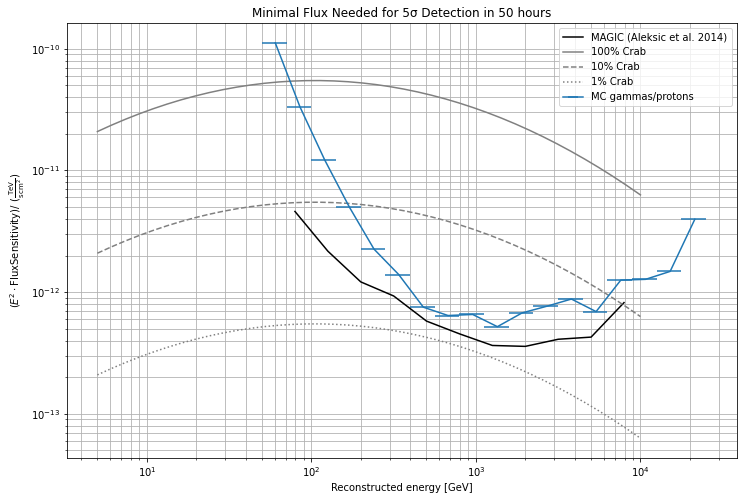

In [34]:
plt.figure(figsize=(12,8))
ax=plt.axes()
unit = u.Unit('TeV cm-2 s-1')

e = sensitivity_mc['reco_energy_center']

s_mc = (e**2 * sensitivity_mc['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.GeV),
    s_mc.to_value(unit),
    xerr=(sensitivity_mc['reco_energy_high'] - sensitivity_mc['reco_energy_low']).to_value(u.GeV) / 2,
    label='MC gammas/protons',
    )

#Plot magic sensitivity
s = np.loadtxt('/home/david.miranda/software/cta-lstchain_v.0.6.3/lstchain/spectra/data/magic_sensitivity.txt', skiprows = 1)
ax.loglog(s[:,0], s[:,3] * np.power(s[:,0]/ 1e3, 2),
              color = 'black', label = 'MAGIC (Aleksic et al. 2014)')

#Plot Crab SED
plot_utils.plot_Crab_SED(ax, 100, 5*u.GeV, 1e4*u.GeV, label="100% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 10, 5*u.GeV, 1e4*u.GeV, linestyle='--', label="10% Crab") #Energy in GeV
plot_utils.plot_Crab_SED(ax, 1, 5*u.GeV, 1e4*u.GeV, linestyle=':', label="1% Crab") #Energy in GeV


# Style settings
plt.title('Minimal Flux Needed for 5σ Detection in 50 hours')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [GeV]")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.grid(which="both")
plt.legend()
plt.show()

In [37]:
proton_hist

reco_energy_low,reco_energy_high,reco_energy_center,n,n_weighted
TeV,TeV,TeV,,
float64,float64,float64,float64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,69.04898195702769,83686.58932792935
0.0706268772311377,0.09976311574844397,0.08519499648979084,105.7514525237114,84215.42948379411
0.09976311574844397,0.14091914656322266,0.12034113115583331,85.59765317300538,76596.13792392676
0.14091914656322266,0.1990535852767486,0.16998636591998562,76.18299498016572,50911.99734766878
0.1990535852767486,0.2811706625951745,0.24011212393596154,37.82033055840686,23827.54824521375
0.2811706625951745,0.39716411736214063,0.3391673899786576,8.462126563663256,4564.1850040832305
0.39716411736214063,0.5610092271509817,0.47908667225656115,0.8886718613724178,395.236835206074
0.5610092271509817,0.7924465962305566,0.6767279116907692,0.0,0.0


In [38]:
gamma_hist

reco_energy_low,reco_energy_high,reco_energy_center,n,n_weighted
TeV,TeV,TeV,,
float64,float64,float64,int64,float64
0.049999999999999996,0.0706268772311377,0.06031343861556884,553,1207.0872699660927
0.0706268772311377,0.09976311574844397,0.08519499648979084,1834,3292.9682719170046
0.09976311574844397,0.14091914656322266,0.12034113115583331,4364,6584.325224033888
0.14091914656322266,0.1990535852767486,0.16998636591998562,7693,9467.225477025922
0.1990535852767486,0.2811706625951745,0.24011212393596154,11629,11655.021551662081
0.2811706625951745,0.39716411736214063,0.3391673899786576,8418,6787.12080050107
0.39716411736214063,0.5610092271509817,0.47908667225656115,4973,3233.312107457881
0.5610092271509817,0.7924465962305566,0.6767279116907692,1085,561.1113671164203


In [39]:
gammas

intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,obs_id,event_id,calibration_id,true_energy,log_mc_energy,true_alt,true_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,pointing_az,pointing_alt,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gh_score,good_events,weight,true_source_fov_offset,reco_source_fov_offset,source_fov_offset,theta,selected_theta,selected_gh,selected
,,,,,,,,,,,,,,,,,,,,,,,,,TeV,,rad,rad,,,,,rad,rad,,,,,,,,,,,,,,,,,TeV,,,,,rad,rad,,,,,deg,deg,deg,deg,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,int32,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bool,float64,float64,float64,float64,float64,bool,bool,bool
842.8172659873962,2.925733424000897,0.2326798870284479,-0.15108514757780694,0.2774286424401399,-0.5759014038011381,0.15726747381159195,0.06841951182095933,-0.2771675147243109,-0.11420503035724984,1.811280594886691,-3.027869131572228,26.26420440089801,0.0,0.0,0.0,0.0,59,0.04140110953399817,0.2609262661151201,0.053366593873074124,2,1000,209,-1,0.1353185921907425,-0.8686425291147142,1.2217304706573486,3.1415927410125732,40.302940368652344,-122.52853393554688,26365.3125,0,3.1415927410125732,1.2217304706573486,198.57142639160156,131.67069582218534,0.4350518906593909,1,-70.93,-52.07,43.0,0,-0.23267867,0.15108515,0.2774276,-0.57590383,-1.0,1.223919e-06,0.0,-0.7440953976673743,0.18026217312301815,0.14412596050793586,-0.04634141150705531,0.3768058475363838,-0.19742655908486226,1.235116905169088,3.1201884908387507,101,0.2041666666666667,True,1.4156754662854307,3.3059086758748746e-07,0.8704682658922785,3.3059086758748746e-07,0.8704679730567799,False,False,False
224.07349491119385,2.3503904879737565,0.0812485893128274,0.23425299835017724,0.24794313965377754,1.2369383566968488,0.0731089506296587,0.029758443213293843,1.3819452669635244,-0.6878023749954785,2.878056885135552,-2.97343681704336,25.34712926085553,0.0,0.0,0.0,0.0,16,0.2758479364377193,0.38041599836130774,0.14893265496383912,1,1000,2402,-1,0.04648441821336746,-1.3326926001854122,1.2217304706573486,3.1415927410125732,-15.65365219116211,51.10258865356445,20238.9296875,0,3.1415927410125732,1.2217304706573486,233.07691955566406,117.04724536411649,0.40704240666834973,1,-70.93,-52.07,43.0,0,-0.08124737,-0.234253,0.24794275,1.236943,-1.0,1.223919e-06,0.0,-1.2436239055904659,0.05706582423414837,0.002592218837876772,0.036217817325342905,0.08384080815070417,0.2704708156755201,1.2245955577972045,3.1700632112876566,101,0.24666666666666667,True,2.7458369812236816,3.3059086758748746e-07,0.5794382659278104,3.3059086758748746e-07,0.5794381680441709,True,False,False
643.6946549415588,2.80867990288534,0.10167894913042928,-0.35493069513864695,0.3692078101122342,-1.2917930432176825,0.2000478140195511,0.039982768056837786,-1.325986728641997,0.1767459937161866,1.7710401074380546,3.5904674250511865,26.37613646781422,0.0,0.0,0.0,0.0,49,0.07177985276318201,0.39492707632192037,0.058799711583794455,1,1000,4701,-1,0.14379432797431946,-0.8422582445375392,1.2217304706573486,3.1415927410125732,-8.855626106262207,-196.48446655273438,26655.546875,0,3.1415927410125732,1.2217304706573486,165.0,157.19022288310802,0.19986605828609647,1,-70.93,-52.07,43.0,0,-0.10167772,0.3549307,0.36920747,-1.2917962,-1.0,1.223919e-06,0.0,-0.841744747

In [41]:
protons

intensity,log_intensity,x,y,r,phi,length,width,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,obs_id,event_id,calibration_id,true_energy,log_mc_energy,true_alt,true_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,pointing_az,pointing_alt,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y,log_reco_energy,reco_energy,reco_disp_dx,reco_disp_dy,reco_src_x,reco_src_y,reco_alt,reco_az,reco_type,gh_score,good_events,weight,true_source_fov_offset,reco_source_fov_offset,theta,selected_gh,selected
,,,,,,,,,,,,,,,,,,,,,,,,,TeV,,rad,rad,,,,,rad,rad,,,,,,,,,,,,,,,,,TeV,,,,,rad,rad,,,,,deg,deg,deg,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,int64,float64,float64,float64,int64,int32,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float32,float32,float64,float64,float64,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,bool,float64,float64,float64,float64,bool,bool
272.9674320220947,2.436110834085337,0.4224041718275432,-0.4686015404201394,0.6308824677080829,-0.8372003432751777,0.06592108548128921,0.040747610102258615,1.4366860308004747,-0.00779692297458131,2.0671906346216185,1.6964901701023958,26.14027332585583,0.0,0.0,0.0,0.0,19,0.27883302649422803,0.4245068368753821,0.13754754974317632,1,2501,88701,-1,0.1559777557849884,-0.8069373325984416,1.2312166690826416,3.058166265487671,-27.692306518554688,-6.866317272186279,9519.181640625,101,3.1415927410125732,1.2217304706573486,557.368408203125,62.552946122083796,0.6181271106924394,1,-70.93,-52.07,43.0,0,-0.12630664,-0.30872002,0.3335587,1.1824441,-1.0,0.29609755,-0.7773216,-1.190133773849675,0.0645455381583449,-0.022493876208314452,0.0048149482224956516,0.39991029561922875,-0.46378659219764373,1.2356209118237407,3.0912229905497504,101,0.10733333333333334,True,1506.4355256731621,1.7020793595620656,1.2531035614793518,1.2531035617752522,False,False
210.38424968719482,2.3230132234570817,-0.5494313777894181,-0.7547973238076734,0.9335919017037391,-2.200015236557002,0.05817767562826936,0.04047983421271583,1.06259507458574,-0.44643626819613585,2.1468582043045035,-3.6906506501143173,25.458591112197745,0.0,0.0,0.0,0.0,17,0.24241728301463425,0.24241728301463425,0.12534508743330097,1,2501,245702,-1,0.4613684415817261,-0.33595211531047914,1.1938244104385376,3.0017635822296143,10.12366008758545,220.43109130859375,25671.404296875,101,3.1415927410125732,1.2217304706573486,201.7073211669922,284.3000887462369,0.6957966913522772,1,-70.93,-52.07,43.0,0,-0.13737331,-0.68279195,0.69647413,1.3722534,-1.0,-0.6868047,-1.4375893,-1.1767662375778345,0.0665631341102095,-0.0002778451113020163,0.00955627040258557,-0.5497092229007201,-0.7452410534050878,1.2011758048007926,3.067874430002083,101,0.04833333333333333,True,769.0236822611778,3.2599142162089323,1.894872171155792,1.8948721716607766,False,False
6699.325170516968,3.826031058002161,-0.6787216599676182,-0.3452045155683382,0.7614651989933422,-2.6710809195656595,0.48131036133780386,0.14878509868736056,-0.977525926896867,-0.9917749143536666,3.085738850476266,-9.429570363646395,30.99415598606482,0.0046499483,0.0140822735,0.0005008138224615,0.0013772380117691248,428,0.008385864645215162,0.4190929780621609,0.013168479314156075,3,2501,267302,-1,7.010843753814697,0.8457702883767259,1.20823073387146,3.0600733757019043,-177.2813720703125,115.72405242919922,30179.8203125,101,3.1415927410125732,1.2217304706573486,223.028564453125,198.6591508200058,0.3091250690589994,1,-70.93,-52.07,43.0,0,0.33172306,-0.46363258,0.5700836,-0.94975185,1.0,-0.3469986,-0.8088371,0.6071816760973473,4.047451711796685,0

In [42]:
output_data_file = '/fefs/home/david.miranda/data/sensitivity/mabel_sensitivity.h5'
sensitivity_mc.write(output_data_file, path='sensitivity/standard', serialize_meta=True)
gammas.write(output_data_file, path='events/gamma_on', serialize_meta=True, append=True)
protons.write(output_data_file, path='events/proton', serialize_meta=True, append=True)

proton_hist.write(output_data_file, path='histogram/proton', serialize_meta=True, append=True)
gamma_hist.write(output_data_file, path='histogram/gamma_on', serialize_meta=True, append=True)

print("sensitivity.hdf5 saved as {}".format(output_data_file))

sensitivity.hdf5 saved as /fefs/home/david.miranda/data/sensitivity/mabel_sensitivity.h5
